## TGS Salt Identification Challenge

https://www.kaggle.com/c/tgs-salt-identification-challenge

In [1]:
# set gpu number
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

## imports

In [2]:
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import StratifiedKFold
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label
import cv2

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
from keras.losses import binary_crossentropy
import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import time
import tqdm

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Image resize

In [3]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size/_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

### Loading of training/testing ids and depths

In [4]:
train_df = pd.read_csv("../train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

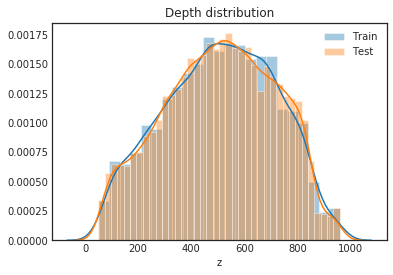

In [5]:
#Plotting the depth distributions
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution");

### load train masks and images

In [6]:
train_df["images"] = [np.array(load_img("../train/images/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in (train_df.index)]
train_df["masks"] = [np.array(load_img("../train/masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in (train_df.index)]

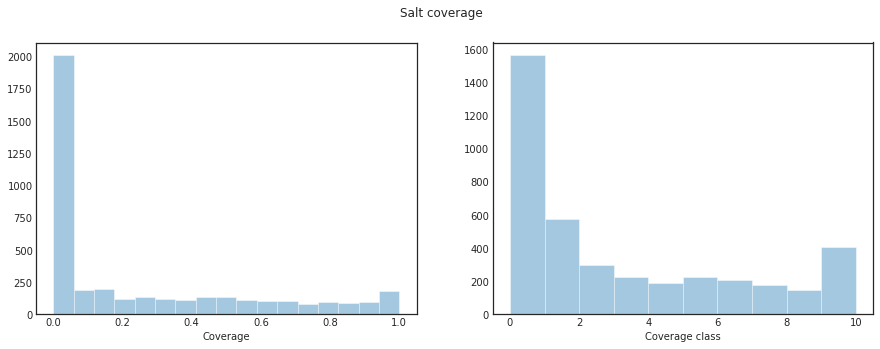

In [7]:
# calc mask coverage
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class");

### load test images

In [8]:
x_test = np.array([(np.array(load_img("../test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in test_df.index]).reshape(-1, img_size_target, img_size_target, 1)
len(x_test)

18000

## create U-net with Resnet Blocks

In [9]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [10]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

### iou metric

In [11]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0], tf.float64)

In [12]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
    intersection = temp1[0]
   
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


### Lovaz loss

In [15]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard
# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        #loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss

def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

### Weighted bce dice loss

In [16]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

### Data agumentation

In [25]:
from skimage.transform import resize, rescale, rotate

def center_crop(x_img, y_img, crop_size=(70, 70)):
    h, w, _ = x_img.shape
    top = (h - crop_size[0]) // 2
    left = (w - crop_size[1]) // 2
    bottom = top + crop_size[0]
    right = left + crop_size[1]
    x_img = x_img[top:bottom, left:right, :]
    y_img = y_img[top:bottom, left:right, :]
    
    x_img = resize(x_img, (h,w))
    y_img = resize(y_img, (h,w))
    return x_img, y_img

def crop1(x_img, y_img):
    h, w, _ = x_img.shape
    x_img = resize(x_img[:64,:64], (h,w))
    y_img = resize(y_img[:64,:64], (h,w))
    return x_img, y_img
  
def crop2(x_img, y_img):
    h, w, _ = x_img.shape
    x_img = resize(x_img[:64,64:], (h,w))
    y_img = resize(y_img[:64,64:], (h,w))
    return x_img, y_img
  
def crop3(x_img, y_img):
    h, w, _ = x_img.shape
    x_img = resize(x_img[64:,:64], (h,w))
    y_img = resize(y_img[64:,:64], (h,w))
    return x_img, y_img
  
def crop4(x_img, y_img):
    h, w, _ = x_img.shape
    x_img = resize(x_img[64:,64:], (h,w))
    y_img = resize(y_img[64:,64:], (h,w))
    return x_img, y_img

def random_crop(x_img, y_img, crop_size=(70, 70)):
    h, w, _ = x_img.shape
    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])
    bottom = top + crop_size[0]
    right = left + crop_size[1]
    
    x_img = x_img[top:bottom, left:right, :]
    y_img = y_img[top:bottom, left:right, :]
    
    x_img = resize(x_img, (h,w))
    y_img = resize(y_img, (h,w))
    return x_img, y_img

def horizontal_flip(x_img, y_img):
    x_img = x_img[:, ::-1, :]
    y_img = y_img[:, ::-1, :]
    return x_img, y_img

def vertical_flip(x_img, y_img):
    x_img = x_img[::-1, :, :]
    y_img = y_img[::-1, :, :]
    return x_img, y_img

def random_rotation(x_img, y_img, angle_range=(-180, 180)):
    h, w, _ = x_img.shape
    angle = np.random.randint(*angle_range)
    x_img = rotate(x_img, angle)
    y_img = rotate(y_img, angle)
    
    #x_img, y_img = center_crop(x_img, y_img, (95, 95))
    x_img = resize(x_img, (h,w))
    y_img = resize(y_img, (h,w))
    return x_img, y_img

### RLE encode

In [19]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

### Test time augmnentation TTA 

In [21]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

### Stratified KFold

In [22]:
def my_stratified_train_valid_sets(n_splits=5, random_state=42):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=False, random_state=random_state)
    train_index_arr = []
    test_index_arr = []
    
    x = np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1) 
    y = np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1) 
    for train_index, valid_index in kf.split(train_df, train_df['coverage_class']):
        yield x[train_index,:,:], x[valid_index], y[train_index], y[valid_index]

## Build 2 stage model.
1 - stage train with weighted_bce_dice_loss
2 - stage train with lovasz_loss

In [23]:
def two_stage_model(x_train, y_train, x_valid, y_valid, test, save_model_name, ifold):
    print("FIRST STAGE FOR FOLD =", ifold)

    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16, 0.5)
    model1 = Model(input_layer, output_layer, name= save_model_name + '_part1')
    
    c = optimizers.adam(lr = 0.01)
    model1.compile(loss=weighted_bce_dice_loss, optimizer=c, metrics=[my_iou_metric])
    
    #early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                       mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max', 
                                  factor=0.5, patience=2, min_lr=0.00001, verbose=1)

    epochs = 150
    batch_size = 32
    history = model1.fit(x_train, y_train,
                      validation_data=[x_valid, y_valid], 
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[ model_checkpoint,reduce_lr, tg_callback], 
                      verbose=2)
    
    print("SECOND STAGE with lovasz_loss FOR FOLD =", ifold)
    model1 = load_model(save_model_name, custom_objects={'my_iou_metric': my_iou_metric,
                                                        'weighted_bce_dice_loss':weighted_bce_dice_loss})
    
    # remove layter activation layer and use losvasz loss
    input_x = model1.layers[0].input
    output_layer = model1.layers[-1].input
    model = Model(input_x, output_layer, name=save_model_name + '_part2')
    c = optimizers.adam(lr = 0.01)
    
    # lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
    # Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
    model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
    
    early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
    model_checkpoint = ModelCheckpoint(save_model_name, monitor='val_my_iou_metric_2', 
                                     mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', 
                                  mode = 'max',factor=0.5, patience=2, min_lr=0.000001, verbose=1)
    epochs = 200
    batch_size = 32
    history = model.fit(x_train, y_train,
                      validation_data=[x_valid, y_valid], 
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                      verbose=2)
    
    model_best = load_model(save_model_name,
                            custom_objects={'my_iou_metric_2': my_iou_metric_2, 'lovasz_loss': lovasz_loss})

    preds_valid = predict_result(model_best, x_valid, img_size_target)

    # best threshold
    thresholds_ori = np.linspace(0.4, 0.75, 101)
    thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 
    ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in thresholds])
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    preds_test = predict_result(model,x_test,img_size_target)
    pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(test_df.index.values)}
    
    # predict with tta
    pred_test_dict = {idx: np.round(downsample(preds_test[i]) > threshold_best) for i, idx in enumerate(test_df.index.values)}
    
    print("RESULTS HAVE BEEN SAVED FOR FOLD =", ifold)
    return pred_test_dict

In [24]:
# config telegram callbacks
from keras_telegram_callbacks.callbacks import TelegramCallback

config = {
    'token': '11111111:xxxxxxxxxxxxxxxxxxxxxxxxxxxx',   # paste your bot token
    'chat_id': 123456789,                               # paste your chat_id
}

proxy_config = {
    "proxy_url":"http://81.130.135.142:48057",
    'username':'',
    'password':''
}

### Calculate prediction on 5 stratified fold

In [ ]:
# calculate 
dir_name = 'Stratified_KFold'
if not(os.path.exists(dir_name)):
    os.mkdir(dir_name)

n_splits = 5
i_fold = 0
kf = my_stratified_train_valid_sets(n_splits=n_splits)
for  x_train, x_valid, y_train, y_valid in kf:
    i_fold += 1
    
    tg_callback = TelegramCallback(config)
    tg_callback.set_proxy(proxy_config)
    
    tg_callback.send_message("*** FOLD "+ str(i_fold) + " ***")
    try:
        x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
        y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
        
        save_model_name = dir_name + '/unet_resnet_' + str(i_fold)
        preds_test_dict =  two_stage_model(x_train, y_train, x_valid, y_valid, x_test, save_model_name, i_fold)
        dump_data(dir_name + '/KFold_'+ str(i_fold), preds_test_dict)

    except Exception as e:
        print("EXCEPTION: "+str(e))
        tg_callback.send_message("EXCEPTION: "+str(e))


FIRST STAGE FOR FOLD = 1
Train on 6392 samples, validate on 804 samples
Epoch 1/150
 - 42s - loss: 1.0856 - my_iou_metric: 0.2422 - val_loss: 1.0559 - val_my_iou_metric: 0.2728

Epoch 00001: val_my_iou_metric improved from -inf to 0.27276, saving model to Stratified_KFold/unet_resnet_1
Epoch 2/150
 - 31s - loss: 0.8220 - my_iou_metric: 0.4356 - val_loss: 2.4982 - val_my_iou_metric: 0.0867

Epoch 00002: val_my_iou_metric did not improve from 0.27276
Epoch 3/150
 - 31s - loss: 0.7110 - my_iou_metric: 0.4863 - val_loss: 1.0110 - val_my_iou_metric: 0.3326

Epoch 00003: val_my_iou_metric improved from 0.27276 to 0.33259, saving model to Stratified_KFold/unet_resnet_1
Epoch 4/150
 - 31s - loss: 0.6714 - my_iou_metric: 0.4813 - val_loss: 1.1529 - val_my_iou_metric: 0.2027

Epoch 00004: val_my_iou_metric did not improve from 0.33259
Epoch 5/150
 - 31s - loss: 0.6294 - my_iou_metric: 0.5038 - val_loss: 0.8047 - val_my_iou_metric: 0.4851

Epoch 00005: val_my_iou_metric improved from 0.33259 to 0

### merge results from 5 fold and save submittion file

In [ ]:
files = ['KFold_1', 'KFold_2', 'KFold_3', 'KFold_4', 'KFold_5']

test_preds1 = load_data(dir_name+'/'+files[0])
test_preds2 = load_data(dir_name+'/'+files[1])
test_preds3 = load_data(dir_name+'/'+files[2])
test_preds4 = load_data(dir_name+'/'+files[3])
test_preds5 = load_data(dir_name+'/'+files[4])

thresh = 0.5
test_preds = {}
for i in test_preds1:
    test_preds[i] = test_preds1[i] + test_preds2[i] + test_preds3[i] + test_preds4[i] + test_preds5[i]
    test_preds[i] = test_preds[i]/len(files)
    test_preds[i] = rle_encode(np.round(test_preds[i] >= thresh))
    

sub = pd.DataFrame()
sub['rle_mask'] = list(test_preds.values())
sub.index = list(test_preds.keys())
sub.index.names = ['id']
sub.to_csv('strative_thresh_' + str(thresh)+'.csv')
sub.head(10)